# Analysis of Hanson's experimental results

## Contents

1. [Set-up](#Set-up)
1. [Results DataFrame](#Results-DataFrame)
1. [Listener accuracy broken down by distractor size](#Listener-accuracy-broken-down-by-distractor-size)
1. [The role of alpha for the incremental S1](#The-role-of-alpha-for-the-incremental-S1)
1. [ROUGE scoring](#ROUGE-scoring)

## Set-up

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use("ggplot")

## Results DataFrame

In [4]:
df = pd.read_csv("rsa_summ_results_2031.csv")

Restrict to the colummns with diverse values to make inspection easier:

In [5]:
cols = ['mode', 'prag_alpha', 'bert_distr_d_factor', 'listener_acc']

cols = [c for c in df.columns if len(df[c].unique()) > 1]

df = df[cols].drop('pred_save_file', axis=1).copy()

In [6]:
df.head()

,id,mode,prag_alpha,bert_distr_d_factor,bert_distr_repl_search_top,bert_distr_repl_search_bottom,bert_distr_exclusion_set,listener_acc,eval_duration,rouge_1r,rouge_1p,rouge_1f,rouge_2r,rouge_2p,rouge_2f,rouge_lr,rouge_lp,rouge_lf,METEOR
0,2,incr_s1,0.50,2,5,10,0,0.528311,635.765002,0.425080,0.503042,0.449594,0.223988,0.262724,0.235246,0.401602,0.474563,0.424590,0.210718
1,3,incr_s1,0.50,2,5,10,3,0.552437,625.441476,0.425911,0.504344,0.450698,0.224997,0.264556,0.236569,0.402485,0.476159,0.425818,0.210457
2,4,incr_s1,0.75,2,5,10,0,0.524865,589.455979,0.425857,0.501904,0.449380,0.224180,0.261399,0.234689,0.402422,0.473682,0.424536,0.210513
3,5,incr_s1,0.75,2,5,10,3,0.552930,579.628515,0.425374,0.501914,0.449317,0.223634,0.261610,0.234457,0.402005,0.474028,0.424570,0.210679
4,6,incr_s1,1.00,2,5,10,0,0.525357,611.857244,0.425464,0.499672,0.448297,0.223024,0.259127,0.233064,0.401387,0.471000,0.422882,0.210332


## Listener accuracy broken down by distractor size

The numbers here look like a clear argument for the incremental S1. 

* Fingers crossed on this holding for `bert_distr_d_factor=10` as well!
* Would it be better to do the average rather than the max? Or maybe the average of the runs with the best `prag_alpha`?

In [7]:
def get_listener_accuracy_by_distractor(df, aggfunc):
    return pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values='listener_acc',
        aggfunc=aggfunc)

In [8]:
get_listener_accuracy_by_distractor(df, aggfunc='max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,0.575086,0.554899
5,0.375185,0.317085
10,0.302806,0.223043


In [9]:
get_listener_accuracy_by_distractor(df, aggfunc='mean')

mode,incr_s1,s0
bert_distr_d_factor,,
2,0.550123,0.547514
5,0.338060,0.304284
10,0.269883,0.208764


Here you can start to see that the S1 advantage is likely bigger for larger distractor sets:

In [10]:
def plot_listener_accuracy_by_distractor(df, aggfunc):
    pt = get_listener_accuracy_by_distractor(df, aggfunc)
    ax = pt.plot()
    ax.set_ylabel('listener_acc')
    ax.set_xticks(df['bert_distr_d_factor'].unique())

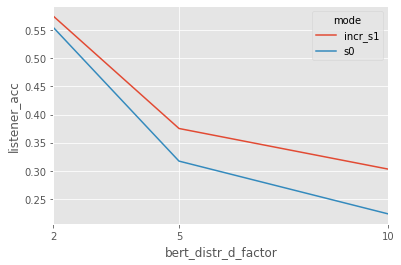

In [11]:
plot_listener_accuracy_by_distractor(df, 'max')

## The role of alpha for the incremental S1

It looks like higher alpha consistently leads to higher accuracy, even for the simpler two-distractor setting.

In [12]:
def plot_accuracy_by_alpha_for_s1(df):
    s1_df = df[df['mode'] == 'incr_s1']
    s1_df_acc = pd.pivot_table(
        s1_df, 
        index='prag_alpha', 
        columns='bert_distr_d_factor', 
        values='listener_acc')
    ax = s1_df_acc.plot()
    ax.set_ylabel('listener_acc')
    ax.set_xticks(s1_df['prag_alpha'].unique())
    return ax

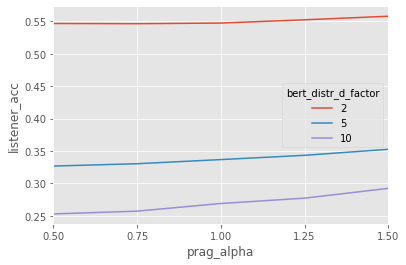

In [13]:
_ = plot_accuracy_by_alpha_for_s1(df)

## ROUGE scoring

The pragmatic model is not ahead here, but I am not sure how surprised we should be by that given the values encoded by ROUGE.

In [13]:
def get_rouge_by_distractor(df, rouge_type, aggfunc):
    rouge_col = "rouge_{}".format(rouge_type)
    pt = pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values=rouge_col,
        aggfunc=aggfunc)
    # Format for faster quick comparisons:
    return (pt * 100).round(3)

In [14]:
get_rouge_by_distractor(df, '1f', 'max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,45.070,45.066
5,44.919,45.066
10,44.610,45.066


In [15]:
get_rouge_by_distractor(df, '2f', 'max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,23.657,23.532
5,23.489,23.532
10,23.239,23.532


In [16]:
get_rouge_by_distractor(df, 'lf', 'max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,42.582,42.619
5,42.411,42.619
10,42.070,42.619


In [20]:
get_rouge_by_distractor(df, '1f', 'mean')

mode,incr_s1,s0
bert_distr_d_factor,,
2,44.767,45.066
5,44.199,45.066
10,43.293,45.066


## METEOR scoring

In [16]:
def get_meteor_by_distractor(df, aggfunc):
    pt = pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values='METEOR',
        aggfunc=aggfunc)
    # Format for faster quick comparisons:
    return (pt * 100).round(3)

In [17]:
get_meteor_by_distractor(df, 'max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,21.078,20.968
5,21.051,20.968
10,20.974,20.968
